# Laminar CSD analysis (work in progress)

This tutorial demonstrates how to perform laminar inference using a CSD analysis of event-related source signals. A temporal Gaussian function is simulated at a particular cortical location in various layers. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh, thus providing an estimate of source activity on each layer. A laminar CSD is run on the laminar signals at the location with the peak variance.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
import k3d
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.laminar import compute_csd
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface, color_map, plot_csd, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas, lpa, rpa = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations and source reconstructions will be based on a forward model using the multilayer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri', 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'multilayer.15.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 15
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/csd'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
08-Jul-2024 20:51:24 - Running job #1
------------------------------------------------------------------------
08-Jul-2024 20:51:24 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           20:51:25 - 08/07/2024
multilayer.15.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definitio

## Simulating a signal on the pial surface
We're going to simulate 200ms of a Gaussian with a dipole moment of 5nAm and a width of 25ms

Text(0, 0.5, 'Amplitude (nAm)')

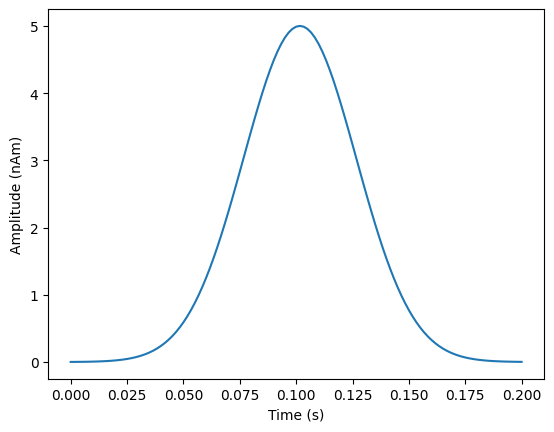

In [6]:
# Strength of simulated activity (nAm)
dipole_moment = 5
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms
# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2)).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [7]:
# Vertex to simulate activity at
sim_vertex=24588

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [8]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
# Orientation of the simulated dipole
pial_unit_norm = mesh.darrays[2].data[pial_vertex,:]
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -5B

 Finish


## Inversion
Now we'll run a source reconstruction using the multilayer mesh, select the vertex to examine, extract the source signals at each layer in that location, and compute a laminar CSD

In [9]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_vertices = np.arange(verts_per_surf)
pial_layer_ts, time, _ = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
peak_coord = ds_inflated.darrays[0].data[peak,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(peak_coord)

Smoothing ../test_data/sub-104/surf/multilayer.15.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/csd/sim_24588_pial_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


-------------------------------------

We can see that the peak is the same as the location we simulated at

In [11]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=peak_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

Output()

507832 vertices


We need the indices of the vertex at each layer for this location, and the distances between them

In [12]:
layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

[0.3404857  0.32851362 0.3285014  0.3284871  0.3284626  0.32844585
 0.3284374  0.32842568 0.32840416 0.32840854 0.32838687 0.32839775
 0.32863343 0.32728985]


Now we can compute and plot the laminar CSD

In [14]:
# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(pial_sim_fname, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, layer_dists, s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(n_layers):
    plt.plot(time, mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(n_layers):
    plt.plot(time, csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

ValueError: Number of signals and coords is not same

In [19]:
[csd, smooth_csd] = compute_csd(mean_layer_ts.T, np.mean(layer_dists), s_rate, smoothing='cubic')

ValueError: Number of signals and coords is not same

In [17]:
mean_layer_ts.shape

(15, 121)

0.3292343

In [22]:
import neo
import quantities as pq
import elephant

sfreq=600
signal = neo.core.AnalogSignal(
    mean_layer_ts, units="T", sampling_rate=sfreq*pq.Hz
)
thickness = pq.Quantity(np.linspace(0, np.mean(layer_dists), num=signal.shape[0]).reshape(-1,1)) * pq.mm

csd = elephant.current_source_density.estimate_csd(
    signal, thickness,
    method = "StandardCSD"
).as_array().T

ValueError: Number of signals and coords is not same

In [26]:
thickness

array([[0.        ],
       [0.02351674],
       [0.04703347],
       [0.07055021],
       [0.09406694],
       [0.11758368],
       [0.14110042],
       [0.16461715],
       [0.18813389],
       [0.21165062],
       [0.23516736],
       [0.25868409],
       [0.28220083],
       [0.30571757],
       [0.3292343 ]]) * mm

## White matter surface simulation with laminar CSD
Let's simulate the same pattern of activity, in the same location, but on the white matter surface.

In [ ]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*int(verts_per_surf)+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)

[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_ts, time, _ = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
peak_coord = ds_inflated.darrays[0].data[peak,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(peak_coord)

layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(white_sim_fname, mu_matrix=MU, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, np.mean(layer_dists), s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(n_layers):
    plt.plot(time, mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(n_layers):
    plt.plot(time, csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

## Simulation in each layer
Let's now simulate on each layer, and for each simulation, run the laminar CSD. We'll turn off SPM visualization here.

In [ ]:
# Now simulate at the corresponding vertex on each layer, and for each simulation compute CSD
layer_csds = []
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    prefix = f'sim_{sim_vertex}_{l}_'
    l_vertex = l*int(verts_per_surf)+sim_vertex

    l_sim_fname = run_dipole_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        pial_unit_norm, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    )

    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes, 
        viz=False,
        return_mu_matrix=True,
        spm_instance=spm
    )

    pial_layer_ts, time, _ = load_source_time_series(
        white_sim_fname, 
        mu_matrix=MU, 
        vertices=pial_layer_vertices
    )

    # Layer peak
    m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
    peak = np.argmax(m_layer_max)

    sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
    peak_coord = ds_inflated.darrays[0].data[peak,:]

    print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')
    print('Simulated coordinate')
    print(sim_coord)
    print('Prior coordinate')
    print(peak_coord)

    layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
    layer_coords = mesh.darrays[0].data[layer_verts,:]
    layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
    print(layer_dists)

    # Get source time series for each layer
    layer_ts, time, _ = load_source_time_series(white_sim_fname, mu_matrix=MU, vertices=layer_verts)

    mean_layer_ts = np.mean(layer_ts,axis=-1)
    [csd, smooth_csd] = compute_csd(mean_layer_ts,np.mean(layer_dists),600,smoothing='cubic')

    col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    for l in range(n_layers):
        plt.plot(time, mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('Source (nAm)')

    plt.subplot(1,3,2)
    for l in range(n_layers):
        plt.plot(time, csd[l,:], label=f'{l}', color=col_r[l,:])
    plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('CSD')

    ax = plt.subplot(1,3,3)
    plot_csd(smooth_csd, time, ax)
    plt.xlabel('Time (ms)')
    plt.ylabel('Layer')
    plt.tight_layout()

    layer_csds.append(smooth_csd)        

For each simulation, we can plot a slice of the CSD through layers around a central time window. The layer model where the CSD signal crosses from negative to positive should correspond to the layer that the activity was simulated in.

In [ ]:
csd_patterns = []
peaks = []
for layer_csd in layer_csds:
    t_idx = np.where((time>=0.09) & (time<=0.11))[0]
    csd_pattern = np.mean(layer_csd[:,t_idx],axis=1)
    for t in range(1,len(csd_pattern)):
        if csd_pattern[t-1]<=0 and csd_pattern[t]>0:
            peaks.append(t/50)
            break
    csd_patterns.append(csd_pattern)
    
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the CV error of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(np.arange(len(csd_patterns[l]))/50,csd_patterns[l], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('CSD')

# For each simulation, find which layer model had the lowest CV error
plt.subplot(1,2,2)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak CSD')
plt.tight_layout()

## Beta burst CSD
That was a simulation of a source in a single layer. Let's try a beta burst simulation, with simultaneous sources in deep and superficial layers (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

In [ ]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

In [ ]:
# Location to simulate activity at
sim_vertex = 24588
# Corresponding pial and white matter vertices
pial_vertex = sim_vertex
white_vertex = (n_layers-1)*int(verts_per_surf)+sim_vertex
pial_coord = mesh.darrays[0].data[pial_vertex,:]
white_coord = mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
white_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'white.gii')
white_mesh = nib.load(white_mesh_fname)

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [ ]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

## Inversion and CSD
Now we'll run a source reconstruction using the multilayer mesh, select the vertex to examine, extract the source signals at each layer in that location, and compute a laminar CSD

In [ ]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    burst_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

pial_layer_vertices = np.arange(verts_per_surf)
pial_layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(pial_layer_ts,axis=-1),-1)
peak = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
peak_coord = ds_inflated.darrays[0].data[peak,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={peak}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(peak_coord)

layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(burst_sim_fname, mu_matrix=MU, vertices=layer_verts)
    
# Average over trials and compute CSD and smoothed CSD
mean_layer_ts = np.mean(layer_ts,axis=-1)
[csd, smooth_csd] = compute_csd(mean_layer_ts, np.mean(layer_dists), s_rate, smoothing='cubic')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for l in range(n_layers):
    plt.plot(mean_layer_ts[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('Source (nAm)')

plt.subplot(1,3,2)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel('CSD')

ax=plt.subplot(1,3,3)
plot_csd(smooth_csd, time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)